In [0]:
!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;

## Στοιχεία Ομάδας

Αριθμός Ομάδας: Μ.Α.11

    > Καρυπιάδης Ευστράτιος: 03114911

---

## Σύνολο δεδομένων

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

# Ένα απλό παράδειγμα υλοποίησης

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [0]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 11s 0us/step


Η κάθε ομάδα θα δουλέψει με 
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό που αντιστοιχεί στην ομάδας σας σε [αυτό το σύνδεσμο](https://docs.google.com/spreadsheets/d/1oEr3yuPg22lmMeqDjFtWjJRzmGQ8N57YIuV-ZOvy3dM/edit?usp=sharing).

In [0]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 11

Στο επόμενο κελί μπορείτε να διαλέξετε το πλήθος των κατηγορίων σας: 20 (default), 40, 60 ή 80.

In [0]:
# select the number of classes
cifar100_classes_url = select_classes_number()

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [0]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [0]:
# print our classes
print(our_classes)

['apple', ' aquarium_fish', ' bicycle', ' boy', ' couch', ' flatfish', ' kangaroo', ' leopard', ' lion', ' mouse', ' mushroom', ' orchid', ' plain', ' plate', ' skunk', ' streetcar', ' sunflower', ' table', ' telephone', ' tulip']


Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


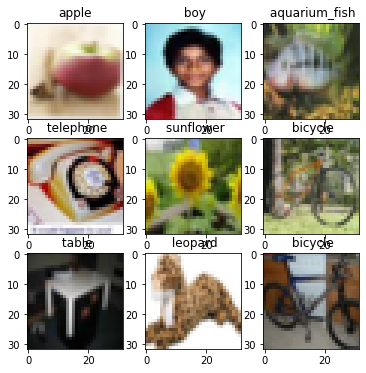

In [0]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [0]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

### Ένα μικρό συνελικτικό δίκτυο "from scratch"

In [0]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  model.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [0]:
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 50, 30, 5)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

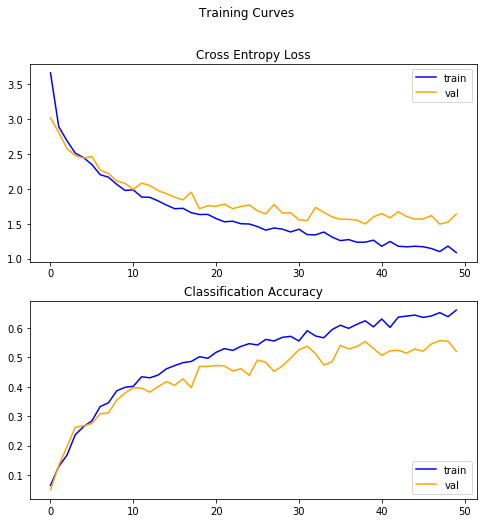


Test set evaluation metrics
30/30 [==============================] - 0s 7ms/step - loss: 1.5614 - accuracy: 0.5555
loss: 1.56
accuracy: 0.56


In [0]:
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, 30)

### Μεταφορά μάθησης: VGG16

In [0]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  # unfreeze conv layers
  VGG16_MODEL.trainable=True

  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [0]:
VGG16_MODEL = init_VGG16_model(summary = True)
VGG16_MODEL_history = train_model(VGG16_MODEL, 25, 40, 10)

58892288/58889256 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Train for 40 steps, validate for 10 steps
Epoch 1/25
40/40 [==============================] - 3s 86ms/step - loss: 3.2556 - accuracy: 0.2031 - val_loss: 1.7827 - val_accuracy:

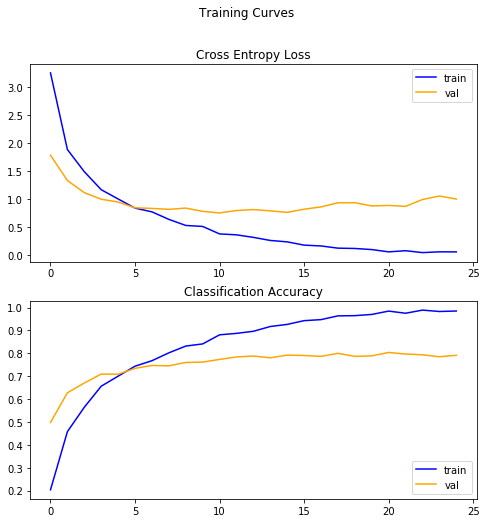


Test set evaluation metrics
30/30 [==============================] - 0s 14ms/step - loss: 1.0188 - accuracy: 0.7872
loss: 1.02
accuracy: 0.79


In [0]:
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

# Βελτίωση της επίδοσης με πειράματα

Καλείστε να βελτιώσετε τα αποτελέσματα ταξινόμησης στο CIFAR-100 και να βγάλατε συμπεράσματα, σύμφωνα με όσα ζητούνται σε σχέση με την αναφορά παράδοσης. 

## Δοκιμές διαφορετικών μοντέλων

Μπορείτε είτε να δοκιμάσετε μοντέλα "from scratch", όπου ορίζετε την αρχιτεκτονική του δικτύου όπως θέλετε, είτε να χρησιμοποιήσετε μεταφορά μάθησης.



### Μοντέλα "from scratch"

Μπορείτε να τροποποιήσετε/αλλάξετε το αρχικό μικρό συνελικτικό δίκτυο του παραδείγματος. Μπορείτε να συμβουλευτείτε 
- τη [βιβλιογραφία απο το leaderboard του CIFAR-100](https://benchmarks.ai/cifar-100) για αρχιτεκτονικές και παραμέτρους των δικτύων
- ή/και να πάρετε ιδέες [από σχετική αναζήτηση στο Google Scholar](https://scholar.google.gr/scholar?hl=en&as_sdt=0%2C5&q=cifar+100+cnn&oq=cifa)

### Μεταφορά μάθησης

Εναλλακτικά, μπορείτε να χρησιμοποιήσετ τη [μεταφορά μάθησης του tf2](https://www.tensorflow.org/tutorials/images/transfer_learning). Σε αντίθεση με τα μοντέλα "from scratch" η μεταφορά μάθησης μας επιστρέφει έτοιμα μοντέλα με προκαθορισμένη αρχιτεκτονική στην οποία μπορούμε γενικά μόνο να προσθέσουμε επίπεδα, τα οποία συνήθως περιορίζοντα σε πλήρως διασυνδεδεμένα επίπεδα που εξειδικεύονται στο συγκεκριμένο task ταξινόμησης που έχουμε να επιτελέσουμε. 

#### Εκπαίδευση βαρών

Ταυτόχρονα με την αρχιτεκτονική, στη μεταφορά μάθησης εισάγουμε και τη γνώση που έχει αποκτήσει το μοντέλο, δηλαδή τις τιμές των βαρών του όπως έχουν προκύψει μετά από εκπαίδευση συνήθως στο (τεράστιο) ImageNet. Οταν εισάγουμε ένα μοντέλο με μεταφορά μάθησης έχουμε τρεις επιλογές για την εκπαίδευση:
- να παγώσουμε τη συνελικτική βάση και να εκπαιδεύσουμε την κεφαλή ταξινόμησης (classification head). Αυτό αντιστοιχεί στο να χρησιμοποιήσουμε τη συνελικτική βάση για εξαγωγή χαρακτηριστικών (feature extraction), σημαία trainable = False.
- να συνεχίσουμε να εκπαιδεύουμε όλα τα επίπεδα του δικτύου, σημαία trainable = True.
- να εκπαιδευτεί μόνο ένα ποσοστό των επιπέδων, εβρισκόμενο προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.



#### Διαθέσιμα μοντέλα για μεταφορά μάθησης στο tf2

1. tf.keras.applications. Ο πιο απλός τρόπος για να κάνουμε μεταφορά μάθησης στο tf2 είναι μέσω του [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) που παρέχει προεκπαιδευμένα μοντέλα από το Keras και συγκεκριμένα τα δίκτυα: DenseNet, Inception-ResNet V2, Inception V3, MobileNet v1, MobileNet v2, NASNet-A, ResNet, ResNet v2, VGG16, VGG19 και Xception V1. Η εισαγωγή των μοντέλων γίνεται παρόμοια με αυτή που δείξαμε παραπάνω για το VGG16.

2. TensorFlow Hub. Μπορείτε επίσης να χρησιμοποιήσετε μοντέλα τα οποία είναι διαθέσιμα στο αποθετήριο [TensoFlow Hub](https://tfhub.dev/s?fine-tunable=yes&module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent&tf-version=tf2) το οποίο περιλαμβάνει πάνω από 100 προεκπαιδευμένα μοντέλα.

3. Αποθηκευμένα μοντέλα απο τρίτες πηγές. Μπορείτε επίσης να κάνετε μεταφορά μάθησης από τρίτες πηγές, είτε του συνόλου του νευρωνικού, αρχιτεκτονικής και βαρών, είτε μόνο της αρχιτεκτονικής ή των βαρών. Το μοντέλο θα πρέπει να έχει αποθηκευθεί σε ένα από τα δύο φορμάτ, Keras HDF5 format (.h5 ή .keras) ή ως στο SavedModel format που αναφέραμε στην εισαγωγή. Τα βάρη μπορούν να εισαχθούν και μόνα τους ως Checkpoints. Για περισσότερα, διαβάστε σχετικά τα λήμματα ["Save and load models"](https://www.tensorflow.org/tutorials/keras/save_and_load), ["Save and serialize"](https://www.tensorflow.org/guide/keras/save_and_serialize), ["Using the SavedModel format"](https://www.tensorflow.org/guide/saved_model) και δείτε για παράδειγμα πως μπορούμε να κάνουμε μεταφορά μάθησης από τα state-of-the-art EfficientNets ([1](https://www.dlology.com/blog/transfer-learning-with-efficientnet/), [2](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnethttps://)).

Σημειώστε ότι πολλά μοντέλα απαιτούν μεγαλύτερες διαστάσεις στην είσοδο από αυτές του CIFAR-100 και κατά συνέπεια τα δεδομένα πρέπει να [μετασχηματιστούν](https://www.tensorflow.org/api_docs/python/tf/image/resize). Προσέξτε ωστόσο τις απαιτήσεις σε μνήμη όταν αυτοί οι μετασχηματισμοί γίνονται απευθείας σε μεταβλητές (βλ. πιο κάτω "Διαχείριση μνήμης"). 


## Παρατηρήσεις ως προς τη βελτιστοποίηση

### Διαχείριση μνήμης (TFRecord)

Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι καθόλου αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούνα να αναγνωστούν γραμμικά. Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε τα σχετικά λήμματα [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data). 

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).



### Υπερεκπαίδευση

Μπορείτε να πειραματιστείτε ως προς τον έλεγχο της υπερεκπαίδευσης (overfitting) με διάφορους τρόπους. Μεταξύ αυτών μπορούμε να αναφέρουμε τους εξής:
- Πρόωρος τερματισμός (early stopping). Μια μέθοδος που τερματίζει την εκπαίδευση αν δεν υπάρχει βελτίωση ως προς τη μετρική απόδοσης που παρακολουθούμε. [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStoppinghttps://)
- Dropout. Μια άλλη τεχνική για τη μείωση της υπερεκπαίδευσης είναι το Dropout. Είναι ένα είδος ομαλοποίησης (regularization) που επιβάλλει στα βάρη του δικτύου να παίρνουν μόνο μικρές τιμές. Εάν εφαρμόσουε dropout σε ένα επίπεδο του δικτύου, τότε ένα ποσοστό των βαρών του γίνεται τυχαία μηδενικό κατά την εκπαίδευση. [Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout)
- Επαύξηση δεδομένων. Η υπερεκπαίδευση συνήθως συμβαίνει όταν έχουμε λίγα ή/και πολύ όμοια δεδομένα εκπαίδευσης. Ένας τρόπος να διορθωθεί αυτό το πρόβλημα είναι να αυξήσουμε τα δεδομένα (data augmentation). Το data augmentation δημιουργεί νέα δεδομένα εκπαίδευσης με βάση τα υπάρχοντα εφαρμόζοντας τυχαίους μετασχηματισμούς ώστε να προκύπτουν αληθοφανείς εικόνες. [Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator)

Βλέπε επίσης [Image classification](https://www.tensorflow.org/tutorials/images/classification).

### Χρόνος εκπαίδευσης

Το TensorFlow 2 προσφέρει νέους ή βελτιώνει διάφορους μηχανισμούς βελτιστοποίησης της εκπαίδευσης. Μεταξύ αυτών έχουμε τους εξής:
- Data prefetching (το χρησιμοποιήσαμε παραπάνω)
- Data reading parallelization 
- Map transformation parallelization
- Caching
- Reducing memory footprint

Συμβουλευτείτε για τα παραπάνω το [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

### Εργαλεία υψηλού επιπέδου

Μεταξύ των εργαλείων βελτιστοποίησης υψηλού επιπέδου (high-level) του TensorFlow μπορούμε να αναφέρουμε τα ακόλουθα:

- [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) και [What-If Tool](https://www.tensorflow.org/tensorboard/what_if_tool) Επικουρικό εργαλείο οπτικοποίησης για τον πειραματισμό στη Μηχανική Μάθηση
- [tf-explain](https://tf-explain.readthedocs.io/en/latest/) Προσφέρει μεθόδους επεξηγισιμότητας για το tf2
- [Keras Tuner](https://github.com/keras-team/keras-tuner) Βελτιστοποίηση υπερπαραμέτρων του Keras στο TensorFlow 2.0
- [AutoAugment](https://github.com/tensorflow/models/tree/master/research/autoaugment) Εκμάθηση της πολιτικης επαύξησης από τα δεδομένα